In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

In [21]:
batch_size = 128
lr = 2e-4
epochs = 30
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dir = "./gan_out"
os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(42)

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # 0..1 -> -1..1
])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.67MB/s]


In [23]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.project = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True)
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.project(z)
        x = x.view(-1, 128, 7, 7)
        x = self.net(x)
        return x


In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [25]:
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

G.apply(weights_init)

Generator(
  (project): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (net): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)

In [26]:
D.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=6272, out_features=1, bias=True)
  )
)

In [27]:
criterion = nn.BCEWithLogitsLoss()
optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

real_label = 1.0
fake_label = 0.0

fixed_z = torch.randn(64, latent_dim, device=device)

In [28]:
def denormalize(img_tensor):
    return (img_tensor + 1.0) / 2.0

def generate_and_save(epoch, n=64):
    G.eval()
    with torch.no_grad():
        z = fixed_z[:n]
        samples = G(z)
        samples = denormalize(samples).cpu()
        grid = utils.make_grid(samples, nrow=8, padding=2)
        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
        plt.title(f"Epoch {epoch}")
        plt.savefig(os.path.join(out_dir, f"gen_epoch_{epoch}.png"), bbox_inches='tight')
        plt.close()

In [31]:
print("Start training on device:", device)
for epoch in range(1, epochs+1):
    G.train()
    D.train()
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for i, (imgs, _) in enumerate(loader):
        b = imgs.size(0)
        imgs = imgs.to(device)


        D.zero_grad()

        labels_real = torch.full((b,), real_label, device=device)
        out_real = D(imgs)
        loss_real = criterion(out_real, labels_real)

        z = torch.randn(b, latent_dim, device=device)
        fake_imgs = G(z)
        labels_fake = torch.full((b,), fake_label, device=device)
        out_fake = D(fake_imgs.detach())
        loss_fake = criterion(out_fake, labels_fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()

        G.zero_grad()
        labels_for_generator = torch.full((b,), real_label, device=device)
        out_fake_for_G = D(fake_imgs)
        loss_G = criterion(out_fake_for_G, labels_for_generator)
        loss_G.backward()
        optG.step()

        epoch_d_loss += loss_D.item()
        epoch_g_loss += loss_G.item()

    avg_d = epoch_d_loss / len(loader)
    avg_g = epoch_g_loss / len(loader)
    print(f"Epoch [{epoch}/{epochs}]  D_loss: {avg_d:.4f}  G_loss: {avg_g:.4f}")

    if epoch % 5 == 0 or epoch == 1 or epoch == epochs:
        generate_and_save(epoch)

Start training on device: cuda
Epoch [1/30]  D_loss: 1.1979  G_loss: 0.8772
Epoch [2/30]  D_loss: 1.1750  G_loss: 0.8939
Epoch [3/30]  D_loss: 1.1532  G_loss: 0.9159
Epoch [4/30]  D_loss: 1.1333  G_loss: 0.9362
Epoch [5/30]  D_loss: 1.1150  G_loss: 0.9587
Epoch [6/30]  D_loss: 1.0987  G_loss: 0.9838
Epoch [7/30]  D_loss: 1.0869  G_loss: 1.0004
Epoch [8/30]  D_loss: 1.0753  G_loss: 1.0155
Epoch [9/30]  D_loss: 1.0661  G_loss: 1.0314
Epoch [10/30]  D_loss: 1.0605  G_loss: 1.0462
Epoch [11/30]  D_loss: 1.0546  G_loss: 1.0628
Epoch [12/30]  D_loss: 1.0447  G_loss: 1.0762
Epoch [13/30]  D_loss: 1.0415  G_loss: 1.0844
Epoch [14/30]  D_loss: 1.0391  G_loss: 1.1000
Epoch [15/30]  D_loss: 1.0369  G_loss: 1.1066
Epoch [16/30]  D_loss: 1.0365  G_loss: 1.1135
Epoch [17/30]  D_loss: 1.0316  G_loss: 1.1230
Epoch [18/30]  D_loss: 1.0311  G_loss: 1.1276
Epoch [19/30]  D_loss: 1.0357  G_loss: 1.1355
Epoch [20/30]  D_loss: 1.0396  G_loss: 1.1382
Epoch [21/30]  D_loss: 1.0313  G_loss: 1.1417
Epoch [22/30

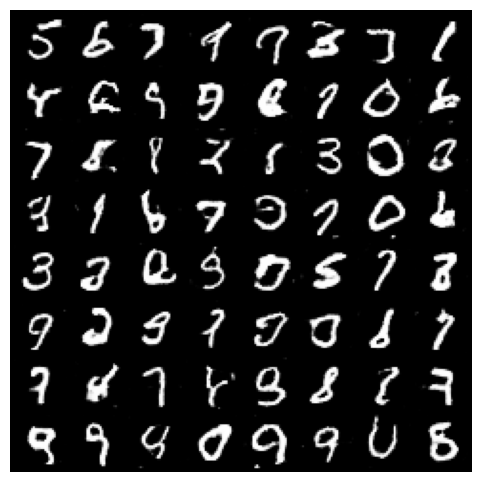

In [32]:
z = torch.randn(64, latent_dim).to(device)
samples = denormalize(G(z)).cpu()
grid = utils.make_grid(samples, nrow=8)
grid = grid.permute(1,2,0).squeeze()

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid, cmap='gray')
plt.show()